# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


!pip install pmdarima
import pmdarima as pmd


In [2]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
#Import dataset
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0000,335400.0000,336500.0000,337600.0000,338500.0000,339500.0000,340400.0000,341300.0000,342600.0000,344400.0000,345700.0000,346700.0000,347800.0000,349000.0000,350400.0000,352000.0000,353900.0000,356200.0000,358800.0000,361800.0000,365700.0000,370200.0000,374700.0000,378900.0000,383500.0000,388300.0000,393300.0000,398500.0000,403800.0000,409100.0000,414600.0000,420100.0000,426200.0000,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0000,236900.0000,236700.0000,235400.0000,233300.0000,230600.0000,227300.0000,223400.0000,219600.0000,215800.0000,211100.0000,205700.0000,200900.0000,196800.0000,193600.0000,191400.0000,190400.0000,190800.0000,192700.0000,196000.0000,201300.0000,207400.0000,212200.0000,214600.0000,215100.0000,213400.0000,210200.0000,206100.0000,202100.0000,198800.0000,196100.0000,194100.0000,193400.0000,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0000,212200.0000,212200.0000,210700.0000,208300.0000,205500.0000,202500.0000,199800.0000,198300.0000,197300.0000,195400.0000,193000.0000,191800.0000,191800.0000,193000.0000,195200.0000,198400.0000,202800.0000,208000.0000,213800.0000,220700.0000,227500.0000,231800.0000,233400.0000,233900.0000,233500.0000,233300.0000,234300.0000,237400.0000,242800.0000,250200.0000,258600.0000,268000.0000,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0000,500900.0000,503100.0000,504600.0000,505500.0000,505700.0000,505300.0000,504200.0000,503600.0000,503400.0000,502200.0000,500000.0000,497900.0000,496300.0000,495200.0000,494700.0000,494900.0000,496200.0000,498600.0000,502000.0000,507600.0000,514900.0000,522200.0000,529500.0000,537900.0000,546900.0000,556400.0000,566100.0000,575600.0000,584800.0000,593500.0000,601600.0000,610100.0000,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0000,77300.0000,77300.0000,77300.0000,77400.0000,77500.0000,77600.0000,77700.0000,77700.0000,77800.0000,77900.0000,77900.0000,77800.0000,77800.0000,77800.0000,77800.0000,77800.0000,77900.0000,78100.0000,78200.0000,78400.0000,78600.0000,78800.0000,79000.0000,79100.0000,79200.0000,79300.0000,79300.0000,79300.0000,79400.0000,79500.0000,79500.0000,79600.0000,...,11

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [5]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.0000,14723.0000,14723.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13684.0000,13685.0000,13685.0000,13685.0000,13685.0000,13685.0000,13685.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,13687.0000,...,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000,14723.0000
mean,81075.0101,48222.3487,7362.0000,118299.1231,118419.0441,118537.4233,118653.0693,118780.2543,118927.5285,119120.5203,119345.3522,119685.0848,120121.2657,120544.2414,120896.6238,121268.1745,121655.8974,122053.1058,122456.3391,122879.9269,123327.4023,123823.1056,124353.7377,125002.6014,125736.6698,126450.7781,127086.2570,127736.3630,128385.0150,129032.7026,129676.3571,130324.5196,130982.6185,131678.0887,132399.3424,133224.7023,134133.5939,135020.8811,135841.5869,136683.7948,...,234691.1907,235760.2798,236836.4260,238009.7602,239354.2077,240744.1214,242103.5251,243424.4447,244658.2694,245764.5656,246765.0411,247765.1701,248896.3662,249987.3124,251014.3109,252164.2736,253483.6378,254820.0842,256205.7801,257597.9148,258946.0232,260254.3164,261576.9001,262923.7927,264373.2595,265755.0975,267065.1158,268533.5054,270226.8424,271824.7164,273335.3936,274865.7746,276464.6200,278033.1862,279520.8585,281095.3202,282657.0604,284368.6884,286511.3768,288039.9443
std,31934.1185,29359.3254,4250.3083,86002.5096,86155.6739,86309.2263,86467.9460,86650.9414,86872.0815,87151.8465,87479.8133,87912.6922,88409.3461,88873.7279,89277.0368,89696.9952,90125.8273,90561.4682,91003.8873,91468.4950,91963.1993,92506.0819,93083.6740,93748.3011,94452.4685,95104.9928,95674.8457,96248.4330,96813.9986,97379.4909,97948.7956,98537.5445,99157.9110,99833.0195,100551.6742,101375.1833,102266.9928,103126.8536,103939.8120,104806.3744,...,307979.0678,312430.3930,316062.1335,317997.8493,319992.4473,323438.7792,327255.3448,330084.8100,331903.6810,333693.4958,335049.9158,336170.1801,337501.9823,338622.7594,339002.5436,339273.5344,340024.1335,340369.1538,340990.8830,343142.2562,346125.0283,348124.8210,349180.8834,349933.4498,350957.6851,351955.9608,353261.0424,355574.0900,357867.8170,359304.0537,360398.4235,361467.7605,362756.2731,364460.9512,365600.3349,367045.3880,369572.7419,371773.9051,372461.2347,372054.3969
min,58196.0000,1001.0000,1.0000,11300.0000,11500.0000,11600.0000,11800.0000,11800.0000,12000.0000,12100.0000,12200.0000,12300.0000,12500.0000,12600.0000,12700.0000,12900.0000,13000.0000,13000.0000,13200.0000,13300.0000,13500.0000,13500.0000,13600.0000,13800.0000,14000.0000,14100.0000,14200.0000,14400.0000,14500.0000,14600.0000,14600.0000,14800.0000,14900.0000,14900.0000,14900.0000,15000.0000,15200.0000,15200.0000,15300.0000,15300.0000,...,13600.0000,13600.0000,13400.0000,13300.0000,13300.0000,13500.0000,13800.0000,14000.0000,14200.0000,14400.0000,14200.000

In [6]:
#Narrow down to Minnesota zipcodes
minnesota_df = df.loc[df['State']== 'MN'].reset_index()
display(minnesota_df.head())
print(f'Number of zipcodes: {len(minnesota_df)}')

,index,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,291,82474,55901,Rochester,MN,Rochester,Olmsted,292,91300.0000,91900.0000,92700.0000,93800.0000,95100.0000,96500.0000,98000.0000,99400.0000,100600.0000,101700.0000,102500.0000,103300.0000,103800.0000,104100.0000,104400.0000,104700.0000,104900.0000,105200.0000,105500.0000,105700.0000,105900.0000,106100.0000,106200.0000,106200.0000,106000.0000,105600.0000,105300.0000,105200.0000,105100.0000,105100.0000,105400.0000,105700.0000,...,165300,165800,166500,167800,168800,169400,170200,171000,171500,172300,173200,174300,175100,176100,177400,179200,181000,182800,184800,186600,187900,189300,190800,191800,192800,193800,195000,196500,198200,199900,201400,202900,204900,206800,208500,210100,211500,212800,213800,214400
1,500,82125,55124,Apple Valley,MN,Minneapolis-St Paul,Dakota,501,122400.0000,122500.0000,122800.0000,123200.0000,123700.0000,124300.0000,125000.0000,125700.0000,126400.0000,127000.0000,127700.0000,128200.0000,128600.0000,129000.0000,129300.0000,129600.0000,129800.0000,130000.0000,130300.0000,130500.0000,130700.0000,130800.0000,131000.0000,131200.0000,131500.0000,131900.0000,132500.0000,133400.0000,134300.0000,135200.0000,136300.0000,137400.0000,...,226600,227700,228900,229900,231100,232100,232300,232700,233700,234400,234100,234200,235500,236700,237500,238200,238900,240100,242000,244000,246200,248300,249300,249500,249800,251500,253800,255700,257600,260000,260900,260200,259300,259500,260900,262900,264200,265600,268400,270800
2,686,82547,56001,Mankato,MN,Mankato,Blue Earth,687,85600.0000,86000.0000,86400.0000,86700.0000,87000.0000,87400.0000,87800.0000,88300.0000,89000.0000,89800.0000,90600.0000,91400.0000,92200.0000,92900.0000,93500.0000,94000.0000,94300.0000,94500.0000,94700.0000,94700.0000,94600.0000,94600.0000,94800.0000,95000.0000,95400.0000,96000.0000,96700.0000,97500.0000,98400.0000,99500.0000,100700.0000,102000.0000,...,159500,159200,158900,159500,160600,162000,162800,163000,163300,164000,164900,165900,167100,168200,169500,171000,172000,172500,172700,172600,172400,172900,174200,175500,176500,177900,179800,181600,183100,184500,185500,186100,187100,188200,188500,188700,189000,188900,188800,189100
3,745,82189,55337,Burnsville,MN,Minneapolis-St Paul,Dakota,746,123200.0000,123100.0000,123000.0000,123000.0000,123100.0000,123300.0000,123600.0000,124000.0000,124500.0000,125000.0000,125600.0000,126100.0000,126600.0000,127000.0000,127400.0000,127800.0000,128300.0000,128700.0000,129100.0000,129500.0000,130100.0000,130700.0000,131400.0000,132000.0000,132600.0000,133300.0000,133900.0000,134500.0000,135200.0000,135900.0000,136700.0000,137600.0000,...,224200,225100,226200,227200,227700,227700,227300,227000,227400,227800,227500,227600,229200,231000,232600,234300,235700,236800,238500,240700,242600,244500,246300,247300,248200,249900,251900,253500,255200,257000,257400,256600,256100,256300,257100,258700,260000,261200,263900,266600
4,859,82063,55044,Lakeville,MN,Minneapolis-St Paul,Dakota,860,138800.0000,138200.0000,138400.0000,139100.0000,140500.0000,142400.0000,144600.0000,147000.0000,149100.0000,151100.0000,153200.0000,155300.0000,156900.0000,158200.0000,159000.0000,159400.0000,159500.0000,159200.0000,158600.0000,157900.0000,156800.0000,155500.0000,154800.0000,154800.0000,155000.0000,155700.0000,156800.0000,158300.0000,160000.0000,161600.0000,162900.0000,163900.0000,...,282400,284200,286400,288300,290000,2911

Number of zipcodes: 375


# Step 2: Data Preprocessing

In [7]:
#Rename RegionName as ZipCode
minnesota_df.rename({'RegionName': 'ZipCode'}, axis=1, inplace=True)
minnesota_df.head()

,index,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,291,82474,55901,Rochester,MN,Rochester,Olmsted,292,91300.0000,91900.0000,92700.0000,93800.0000,95100.0000,96500.0000,98000.0000,99400.0000,100600.0000,101700.0000,102500.0000,103300.0000,103800.0000,104100.0000,104400.0000,104700.0000,104900.0000,105200.0000,105500.0000,105700.0000,105900.0000,106100.0000,106200.0000,106200.0000,106000.0000,105600.0000,105300.0000,105200.0000,105100.0000,105100.0000,105400.0000,105700.0000,...,165300,165800,166500,167800,168800,169400,170200,171000,171500,172300,173200,174300,175100,176100,177400,179200,181000,182800,184800,186600,187900,189300,190800,191800,192800,193800,195000,196500,198200,199900,201400,202900,204900,206800,208500,210100,211500,212800,213800,214400
1,500,82125,55124,Apple Valley,MN,Minneapolis-St Paul,Dakota,501,122400.0000,122500.0000,122800.0000,123200.0000,123700.0000,124300.0000,125000.0000,125700.0000,126400.0000,127000.0000,127700.0000,128200.0000,128600.0000,129000.0000,129300.0000,129600.0000,129800.0000,130000.0000,130300.0000,130500.0000,130700.0000,130800.0000,131000.0000,131200.0000,131500.0000,131900.0000,132500.0000,133400.0000,134300.0000,135200.0000,136300.0000,137400.0000,...,226600,227700,228900,229900,231100,232100,232300,232700,233700,234400,234100,234200,235500,236700,237500,238200,238900,240100,242000,244000,246200,248300,249300,249500,249800,251500,253800,255700,257600,260000,260900,260200,259300,259500,260900,262900,264200,265600,268400,270800
2,686,82547,56001,Mankato,MN,Mankato,Blue Earth,687,85600.0000,86000.0000,86400.0000,86700.0000,87000.0000,87400.0000,87800.0000,88300.0000,89000.0000,89800.0000,90600.0000,91400.0000,92200.0000,92900.0000,93500.0000,94000.0000,94300.0000,94500.0000,94700.0000,94700.0000,94600.0000,94600.0000,94800.0000,95000.0000,95400.0000,96000.0000,96700.0000,97500.0000,98400.0000,99500.0000,100700.0000,102000.0000,...,159500,159200,158900,159500,160600,162000,162800,163000,163300,164000,164900,165900,167100,168200,169500,171000,172000,172500,172700,172600,172400,172900,174200,175500,176500,177900,179800,181600,183100,184500,185500,186100,187100,188200,188500,188700,189000,188900,188800,189100
3,745,82189,55337,Burnsville,MN,Minneapolis-St Paul,Dakota,746,123200.0000,123100.0000,123000.0000,123000.0000,123100.0000,123300.0000,123600.0000,124000.0000,124500.0000,125000.0000,125600.0000,126100.0000,126600.0000,127000.0000,127400.0000,127800.0000,128300.0000,128700.0000,129100.0000,129500.0000,130100.0000,130700.0000,131400.0000,132000.0000,132600.0000,133300.0000,133900.0000,134500.0000,135200.0000,135900.0000,136700.0000,137600.0000,...,224200,225100,226200,227200,227700,227700,227300,227000,227400,227800,227500,227600,229200,231000,232600,234300,235700,236800,238500,240700,242600,244500,246300,247300,248200,249900,251900,253500,255200,257000,257400,256600,256100,256300,257100,258700,260000,261200,263900,266600
4,859,82063,55044,Lakeville,MN,Minneapolis-St Paul,Dakota,860,138800.0000,138200.0000,138400.0000,139100.0000,140500.0000,142400.0000,144600.0000,147000.0000,149100.0000,151100.0000,153200.0000,155300.0000,156900.0000,158200.0000,159000.0000,159400.0000,159500.0000,159200.0000,158600.0000,157900.0000,156800.0000,155500.0000,154800.0000,154800.0000,155000.0000,155700.0000,156800.0000,158300.0000,160000.0000,161600.0000,162900.0000,163900.0000,...,282400,284200,286400,288300,290000,291100,

In [8]:
#Drop unnecessary columns
minnesota_df.drop(['index', 'RegionID', 'State', 'CountyName'], axis=1, inplace=True)
minnesota_df.head()

,ZipCode,City,Metro,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,55901,Rochester,Rochester,292,91300.0000,91900.0000,92700.0000,93800.0000,95100.0000,96500.0000,98000.0000,99400.0000,100600.0000,101700.0000,102500.0000,103300.0000,103800.0000,104100.0000,104400.0000,104700.0000,104900.0000,105200.0000,105500.0000,105700.0000,105900.0000,106100.0000,106200.0000,106200.0000,106000.0000,105600.0000,105300.0000,105200.0000,105100.0000,105100.0000,105400.0000,105700.0000,106200.0000,106800.0000,107800.0000,109000.0000,...,165300,165800,166500,167800,168800,169400,170200,171000,171500,172300,173200,174300,175100,176100,177400,179200,181000,182800,184800,186600,187900,189300,190800,191800,192800,193800,195000,196500,198200,199900,201400,202900,204900,206800,208500,210100,211500,212800,213800,214400
1,55124,Apple Valley,Minneapolis-St Paul,501,122400.0000,122500.0000,122800.0000,123200.0000,123700.0000,124300.0000,125000.0000,125700.0000,126400.0000,127000.0000,127700.0000,128200.0000,128600.0000,129000.0000,129300.0000,129600.0000,129800.0000,130000.0000,130300.0000,130500.0000,130700.0000,130800.0000,131000.0000,131200.0000,131500.0000,131900.0000,132500.0000,133400.0000,134300.0000,135200.0000,136300.0000,137400.0000,138600.0000,139900.0000,141200.0000,142700.0000,...,226600,227700,228900,229900,231100,232100,232300,232700,233700,234400,234100,234200,235500,236700,237500,238200,238900,240100,242000,244000,246200,248300,249300,249500,249800,251500,253800,255700,257600,260000,260900,260200,259300,259500,260900,262900,264200,265600,268400,270800
2,56001,Mankato,Mankato,687,85600.0000,86000.0000,86400.0000,86700.0000,87000.0000,87400.0000,87800.0000,88300.0000,89000.0000,89800.0000,90600.0000,91400.0000,92200.0000,92900.0000,93500.0000,94000.0000,94300.0000,94500.0000,94700.0000,94700.0000,94600.0000,94600.0000,94800.0000,95000.0000,95400.0000,96000.0000,96700.0000,97500.0000,98400.0000,99500.0000,100700.0000,102000.0000,103400.0000,104900.0000,106500.0000,108300.0000,...,159500,159200,158900,159500,160600,162000,162800,163000,163300,164000,164900,165900,167100,168200,169500,171000,172000,172500,172700,172600,172400,172900,174200,175500,176500,177900,179800,181600,183100,184500,185500,186100,187100,188200,188500,188700,189000,188900,188800,189100
3,55337,Burnsville,Minneapolis-St Paul,746,123200.0000,123100.0000,123000.0000,123000.0000,123100.0000,123300.0000,123600.0000,124000.0000,124500.0000,125000.0000,125600.0000,126100.0000,126600.0000,127000.0000,127400.0000,127800.0000,128300.0000,128700.0000,129100.0000,129500.0000,130100.0000,130700.0000,131400.0000,132000.0000,132600.0000,133300.0000,133900.0000,134500.0000,135200.0000,135900.0000,136700.0000,137600.0000,138700.0000,139900.0000,141200.0000,142600.0000,...,224200,225100,226200,227200,227700,227700,227300,227000,227400,227800,227500,227600,229200,231000,232600,234300,235700,236800,238500,240700,242600,244500,246300,247300,248200,249900,251900,253500,255200,257000,257400,256600,256100,256300,257100,258700,260000,261200,263900,266600
4,55044,Lakeville,Minneapolis-St Paul,860,138800.0000,138200.0000,138400.0000,139100.0000,140500.0000,142400.0000,144600.0000,147000.0000,149100.0000,151100.0000,153200.0000,155300.0000,156900.0000,158200.0000,159000.0000,159400.0000,159500.0000,159200.0000,158600.0000,157900.0000,156800.0000,155500.0000,154800.0000,154800.0000,155000.0000,155700.0000,156800.0000,158300.0000,160000.

In [9]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[4:], format='%Y-%m')

In [10]:
get_datetimes(minnesota_df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [11]:
#Change ZipCode dtype to 'str'
minnesota_df['ZipCode'] = minnesota_df['ZipCode'].astype(str)
minnesota_df.dtypes

ZipCode      object
City         object
Metro        object
SizeRank      int64
1996-04     float64
             ...   
2017-12       int64
2018-01       int64
2018-02       int64
2018-03       int64
2018-04       int64
Length: 269, dtype: object

In [12]:
#Calculate ROI percentages since 1996
minnesota_df['ROI'] = round(((minnesota_df['2018-04'] - minnesota_df['1996-04'])/ minnesota_df['1996-04'])*100,4)
minnesota_df.head()

,ZipCode,City,Metro,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,...,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
0,55901,Rochester,Rochester,292,91300.0000,91900.0000,92700.0000,93800.0000,95100.0000,96500.0000,98000.0000,99400.0000,100600.0000,101700.0000,102500.0000,103300.0000,103800.0000,104100.0000,104400.0000,104700.0000,104900.0000,105200.0000,105500.0000,105700.0000,105900.0000,106100.0000,106200.0000,106200.0000,106000.0000,105600.0000,105300.0000,105200.0000,105100.0000,105100.0000,105400.0000,105700.0000,106200.0000,106800.0000,107800.0000,109000.0000,...,165800,166500,167800,168800,169400,170200,171000,171500,172300,173200,174300,175100,176100,177400,179200,181000,182800,184800,186600,187900,189300,190800,191800,192800,193800,195000,196500,198200,199900,201400,202900,204900,206800,208500,210100,211500,212800,213800,214400,134.8302
1,55124,Apple Valley,Minneapolis-St Paul,501,122400.0000,122500.0000,122800.0000,123200.0000,123700.0000,124300.0000,125000.0000,125700.0000,126400.0000,127000.0000,127700.0000,128200.0000,128600.0000,129000.0000,129300.0000,129600.0000,129800.0000,130000.0000,130300.0000,130500.0000,130700.0000,130800.0000,131000.0000,131200.0000,131500.0000,131900.0000,132500.0000,133400.0000,134300.0000,135200.0000,136300.0000,137400.0000,138600.0000,139900.0000,141200.0000,142700.0000,...,227700,228900,229900,231100,232100,232300,232700,233700,234400,234100,234200,235500,236700,237500,238200,238900,240100,242000,244000,246200,248300,249300,249500,249800,251500,253800,255700,257600,260000,260900,260200,259300,259500,260900,262900,264200,265600,268400,270800,121.2418
2,56001,Mankato,Mankato,687,85600.0000,86000.0000,86400.0000,86700.0000,87000.0000,87400.0000,87800.0000,88300.0000,89000.0000,89800.0000,90600.0000,91400.0000,92200.0000,92900.0000,93500.0000,94000.0000,94300.0000,94500.0000,94700.0000,94700.0000,94600.0000,94600.0000,94800.0000,95000.0000,95400.0000,96000.0000,96700.0000,97500.0000,98400.0000,99500.0000,100700.0000,102000.0000,103400.0000,104900.0000,106500.0000,108300.0000,...,159200,158900,159500,160600,162000,162800,163000,163300,164000,164900,165900,167100,168200,169500,171000,172000,172500,172700,172600,172400,172900,174200,175500,176500,177900,179800,181600,183100,184500,185500,186100,187100,188200,188500,188700,189000,188900,188800,189100,120.9112
3,55337,Burnsville,Minneapolis-St Paul,746,123200.0000,123100.0000,123000.0000,123000.0000,123100.0000,123300.0000,123600.0000,124000.0000,124500.0000,125000.0000,125600.0000,126100.0000,126600.0000,127000.0000,127400.0000,127800.0000,128300.0000,128700.0000,129100.0000,129500.0000,130100.0000,130700.0000,131400.0000,132000.0000,132600.0000,133300.0000,133900.0000,134500.0000,135200.0000,135900.0000,136700.0000,137600.0000,138700.0000,139900.0000,141200.0000,142600.0000,...,225100,226200,227200,227700,227700,227300,227000,227400,227800,227500,227600,229200,231000,232600,234300,235700,236800,238500,240700,242600,244500,246300,247300,248200,249900,251900,253500,255200,257000,257400,256600,256100,256300,257100,258700,260000,261200,263900,266600,116.3961
4,55044,Lakeville,Minneapolis-St Paul,860,138800.0000,138200.0000,138400.0000,139100.0000,140500.0000,142400.0000,144600.0000,147000.0000,149100.0000,151100.0000,153200.0000,155300.0000,156900.0000,158200.0000,159000.0000,159400.0000,159500.0000,159200.0000,158600.0000,157900.0000,156800.0000,155500.0000,154800.0000,154800.0000,155000.0000,155700.0000,156800.0000,158300.0000,160

In [13]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'Metro', 'SizeRank', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [14]:
#Reshape dataset from Wide to Long Format
melted_minnesota_df = melt_data(minnesota_df)
display(melted_minnesota_df.head())
display(melted_minnesota_df.info())

,ZipCode,City,Metro,SizeRank,ROI,time,value
0,55901,Rochester,Rochester,292,134.8302,1996-04-01,91300.0000
1,55124,Apple Valley,Minneapolis-St Paul,501,121.2418,1996-04-01,122400.0000
2,56001,Mankato,Mankato,687,120.9112,1996-04-01,85600.0000
3,55337,Burnsville,Minneapolis-St Paul,746,116.3961,1996-04-01,123200.0000
4,55044,Lakeville,Minneapolis-St Paul,860,146.1816,1996-04-01,138800.0000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 94384 entries, 0 to 99374
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ZipCode   94384 non-null  object        
 1   City      94384 non-null  object        
 2   Metro     85345 non-null  object        
 3   SizeRank  94384 non-null  int64         
 4   ROI       91160 non-null  float64       
 5   time      94384 non-null  datetime64[ns]
 6   value     94384 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.8+ MB


None

In [15]:
#Set 'time' column as index to create time series
melted_minnesota_df.set_index('time', inplace=True)

In [16]:
display(melted_minnesota_df.head())
display(melted_minnesota_df.tail())
display(melted_minnesota_df.info())
melted_minnesota_df.index

,ZipCode,City,Metro,SizeRank,ROI,value
time,,,,,,
1996-04-01,55901,Rochester,Rochester,292,134.8302,91300.0000
1996-04-01,55124,Apple Valley,Minneapolis-St Paul,501,121.2418,122400.0000
1996-04-01,56001,Mankato,Mankato,687,120.9112,85600.0000
1996-04-01,55337,Burnsville,Minneapolis-St Paul,746,116.3961,123200.0000
1996-04-01,55044,Lakeville,Minneapolis-St Paul,860,146.1816,138800.0000


,ZipCode,City,Metro,SizeRank,ROI,value
time,,,,,,
2018-04-01,56314,Bowlus,NaN,14630,348.4076,211200.0000
2018-04-01,56010,Amboy,Mankato,14652,nan,118300.0000
2018-04-01,55065,Randolph,Minneapolis-St Paul,14657,151.3146,277200.0000
2018-04-01,56578,Rochert,NaN,14663,330.9091,237000.0000
2018-04-01,56120,Butterfield,NaN,14670,nan,133600.0000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94384 entries, 1996-04-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ZipCode   94384 non-null  object 
 1   City      94384 non-null  object 
 2   Metro     85345 non-null  object 
 3   SizeRank  94384 non-null  int64  
 4   ROI       91160 non-null  float64
 5   value     94384 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.0+ MB


None

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=94384, freq=None)

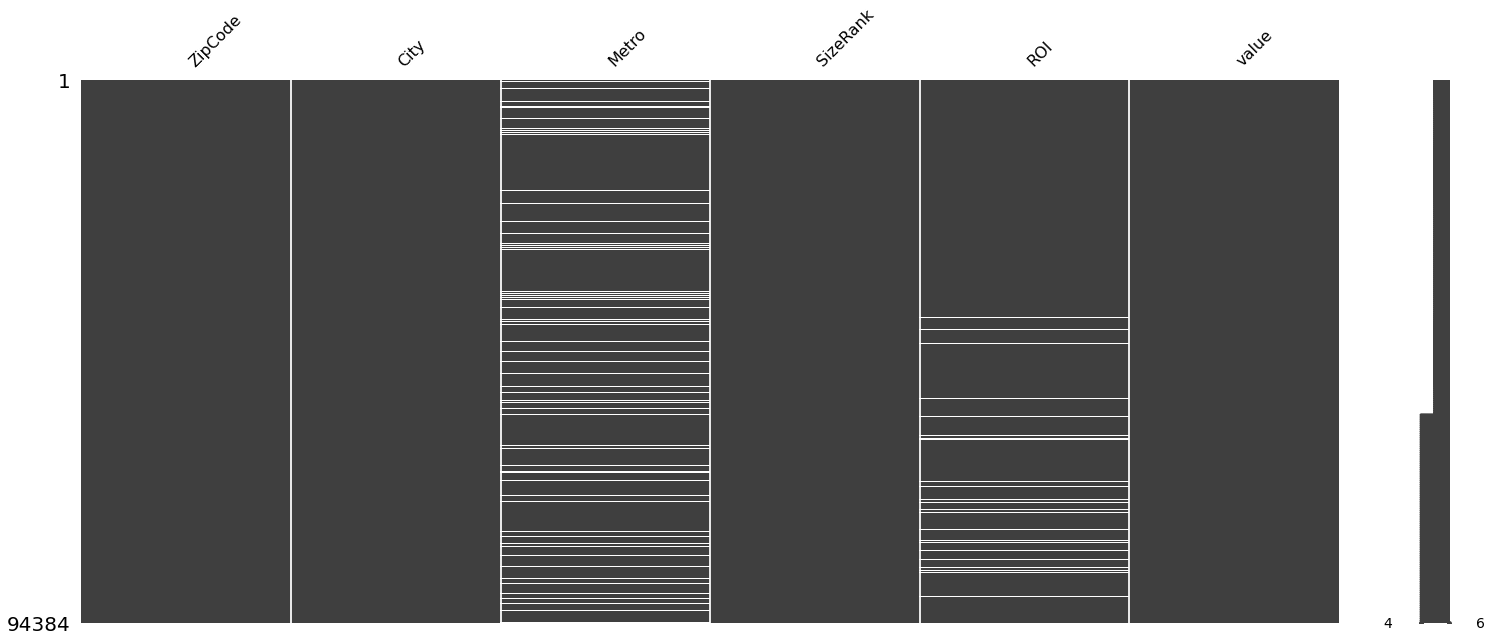

,#null,%null
ZipCode,0,0.0000
City,0,0.0000
Metro,9039,9.5800
SizeRank,0,0.0000
ROI,3224,3.4200
value,0,0.0000


In [17]:
#Check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

missingno.matrix(melted_minnesota_df)
plt.show()
null_check = pd.DataFrame({
    '#null':melted_minnesota_df.isna().sum(),
    '%null':round(melted_minnesota_df.isna().sum()/len(melted_minnesota_df)*100,2)
})
null_check

In [18]:
#Fill 'Metro' nulls with 'Missing'
melted_minnesota_df['Metro'].fillna('Missing', inplace = True)

In [19]:
#Fill in 'ROI' nulls
melted_minnesota_df['ROI'].fillna(melted_minnesota_df['ROI'].mean(), inplace=True)

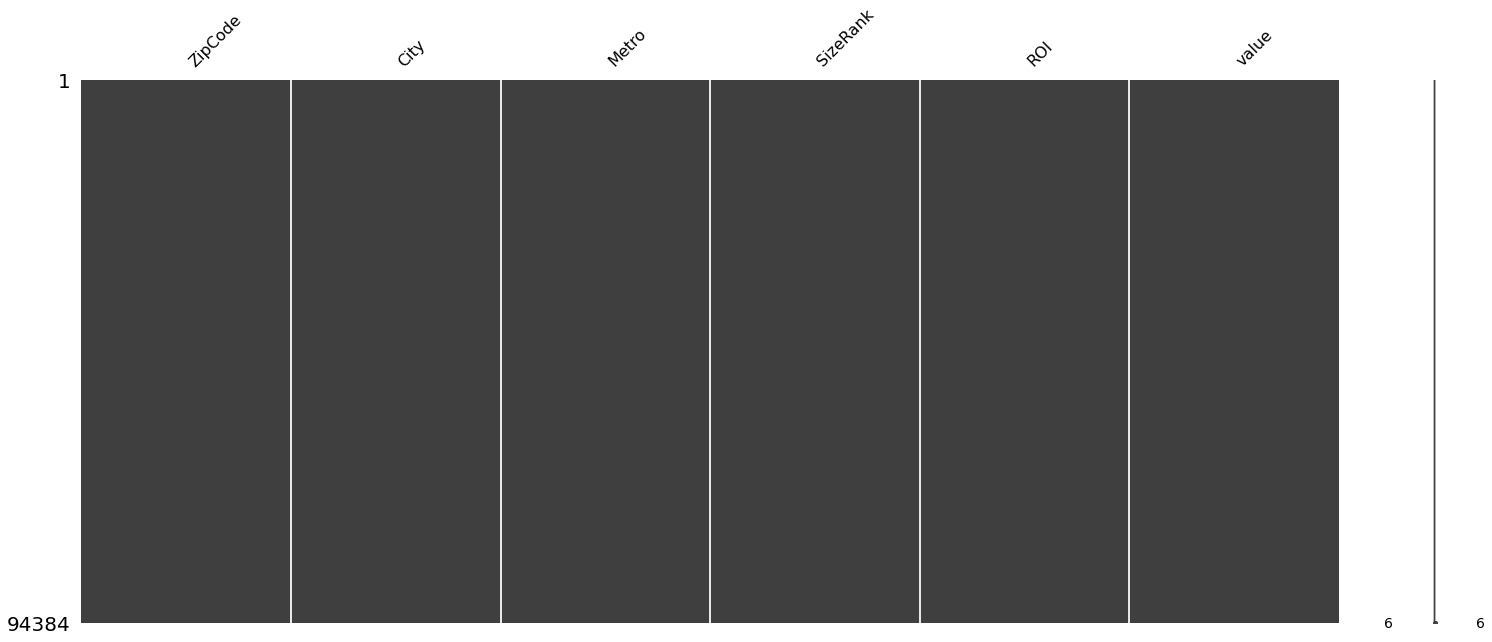

,#null,%null
ZipCode,0,0.0000
City,0,0.0000
Metro,0,0.0000
SizeRank,0,0.0000
ROI,0,0.0000
value,0,0.0000


In [20]:
missingno.matrix(melted_minnesota_df)
plt.show()
null_check = pd.DataFrame({
    '#null':melted_minnesota_df.isna().sum(),
    '%null':round(melted_minnesota_df.isna().sum()/len(melted_minnesota_df)*100,2)
})
null_check

In [21]:
display(melted_minnesota_df['ZipCode'].unique())
melted_minnesota_df['ZipCode'].nunique()

array(['55901', '55124', '56001', '55337', '55044', '55106', '55303',
       '55104', '55113', '55112', '56560', '55408', '55416', '55125',
       '55117', '55406', '55304', '55379', '55110', '55119', '55423',
       '55407', '55330', '55369', '55987', '55082', '55414', '56601',
       '55433', '55418', '55122', '55109', '56401', '55311', '55404',
       '55432', '55118', '55343', '55422', '56308', '55372', '56301',
       '55016', '55116', '55443', '55421', '55426', '55060', '55428',
       '55912', '55024', '55128', '55033', '56303', '55021', '55403',
       '55904', '55105', '55434', '55347', '55126', '55417', '55811',
       '55419', '55448', '55318', '55429', '55449', '55902', '55068',
       '55427', '55378', '55305', '55102', '55014', '55411', '56201',
       '55025', '55420', '55123', '55446', '55744', '55076', '55313',
       '55345', '55447', '55316', '55410', '55412', '56501', '55437',
       '55075', '55431', '55057', '55038', '55066', '55317', '55746',
       '55430', '554

375

# Step 3: EDA and Visualization

In [22]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}

#mpl.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

<AxesSubplot:xlabel='time'>

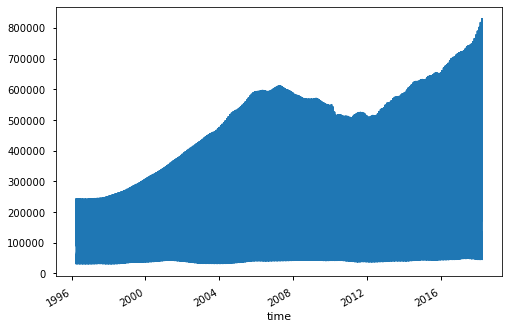

In [23]:
melted_minnesota_df['value'].plot()

In [24]:
#Select the top 5% performing ZipCodes based on calculated ROI
bottom_ninety_five_percent_zipcodes = melted_minnesota_df['ROI'].quantile(q=0.95)
top_5_percent_zipcodes = melted_minnesota_df.loc[melted_minnesota_df['ROI']>=bottom_ninety_five_percent_zipcodes]
top_5_percent_zipcodes.head()

,ZipCode,City,Metro,SizeRank,ROI,value
time,,,,,,
1996-04-01,55408,Minneapolis,Minneapolis-St Paul,1219,290.6815,71900.0000
1996-04-01,55449,Blaine,Minneapolis-St Paul,3956,547.0703,51200.0000
1996-04-01,56501,Detroit Lakes,Missing,5245,300.3731,53600.0000
1996-04-01,56442,Cross Lake,Brainerd,10415,291.5209,74300.0000
1996-04-01,56544,Frazee,Missing,10551,299.7881,47200.0000


In [25]:
top_5_percent_zipcodes.drop(['Metro', 'SizeRank'], axis=1, inplace=True)
top_5_percent_zipcodes.head()

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ZipCode,City,ROI,value
time,,,,
1996-04-01,55408,Minneapolis,290.6815,71900.0000
1996-04-01,55449,Blaine,547.0703,51200.0000
1996-04-01,56501,Detroit Lakes,300.3731,53600.0000
1996-04-01,56442,Cross Lake,291.5209,74300.0000
1996-04-01,56544,Frazee,299.7881,47200.0000


In [27]:
top_5_percent_zipcodes['ZipCode'].nunique()

18

In [29]:
#Create list of top 5% zipcodes
top_5_percent_zipcodes_list = top_5_percent_zipcodes['ZipCode'].unique().tolist()
top_5_percent_zipcodes_list

['55408',
 '55449',
 '56501',
 '56442',
 '56544',
 '55415',
 '56452',
 '56466',
 '56554',
 '56571',
 '56511',
 '56340',
 '56443',
 '56338',
 '56569',
 '56570',
 '56314',
 '56578']

In [31]:
#Create Time Series DataFrames for each ZipCode
all_time_series = {}
for zipcode in top_5_percent_zipcodes_list:
    zipcode_df = top_5_percent_zipcodes.groupby('ZipCode').get_group(zipcode).sort_index()['value']
    all_time_series[zipcode] = zipcode_df

In [32]:
all_time_series.keys()

dict_keys(['55408', '55449', '56501', '56442', '56544', '55415', '56452', '56466', '56554', '56571', '56511', '56340', '56443', '56338', '56569', '56570', '56314', '56578'])

In [34]:
all_time_series_df = pd.DataFrame(all_time_series)
all_time_series_df.head()

,55408,55449,56501,56442,56544,55415,56452,56466,56554,56571,56511,56340,56443,56338,56569,56570,56314,56578
time,,,,,,,,,,,,,,,,,,
1996-04-01,71900.0000,51200.0000,53600.0000,74300.0000,47200.0000,101400.0000,53800.0000,38500.0000,56400.0000,53700.0000,59200.0000,49100.0000,59500.0000,56300.0000,40300.0000,44200.0000,47100.0000,55000.0000
1996-05-01,72000.0000,53300.0000,53700.0000,74600.0000,47200.0000,102800.0000,53500.0000,38800.0000,56400.0000,53800.0000,59300.0000,49300.0000,59700.0000,56200.0000,40300.0000,44100.0000,47400.0000,54800.0000
1996-06-01,72100.0000,55300.0000,53900.0000,74900.0000,47200.0000,104100.0000,53100.0000,39100.0000,56300.0000,54000.0000,59500.0000,49600.0000,59900.0000,56000.0000,40200.0000,44100.0000,47700.0000,54700.0000
1996-07-01,72200.0000,57200.0000,54000.0000,75200.0000,47200.0000,105400.0000,52700.0000,39500.0000,56300.0000,54000.0000,59700.0000,49800.0000,60100.0000,55700.0000,40100.0000,44100.0000,48000.0000,54600.0000
1996-08-01,72400.0000,59100.0000,54100.0000,75500.0000,47200.0000,106500.0000,52400.0000,39900.0000,56400.0000,54100.0000,59900.0000,50100.0000,60400.0000,55400.0000,40100.0000,44100.0000,48400.0000,54500.0000


In [35]:
#Resample timeseries as Weekly
all_time_series_df_weekly = all_time_series_df.resample('W').sum()
all_time_series_df_weekly.index

DatetimeIndex(['1996-04-07', '1996-04-14', '1996-04-21', '1996-04-28',
               '1996-05-05', '1996-05-12', '1996-05-19', '1996-05-26',
               '1996-06-02', '1996-06-09',
               ...
               '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=1148, freq='W-SUN')

<AxesSubplot:xlabel='time'>

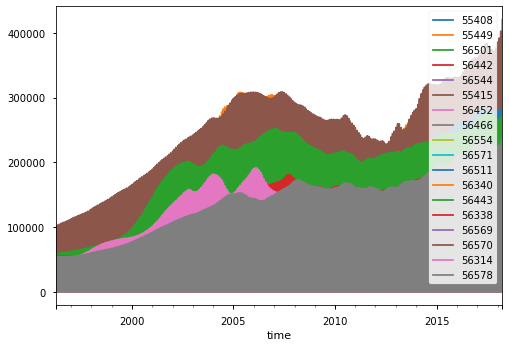

In [39]:
all_time_series_df_weekly.plot()

In [ ]:
#Create Dickey Fuller Test test function
def adfuller_test_df(ts,index=['AD Fuller Results']):
    """Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)

    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df

In [ ]:
#Create Stationarity evaluation function
def stationarity_check(TS,window=8,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        
        ## Building in contingency if not a series with a freq
        try: 
            freq = TS.index.freq
        except:
            freq = 'N/A'
            
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={freq}')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results